### Authors:
 - Mads Bertelsen (ESS)
 - Mousumi Upadhyay Kahaly (ELI-ALPS)
 - Shervin Nourbakhsh (ILL)

# ASE input files
ASE can take in input several file formats.
In this demo we will check that the conversion is done properly and that the output of the Quantum-Espresso (QE) simulation can be carried on with them.

In the following only CIF files will be considered as inputs for the simulation workflow


### Convert CIF to QE input file
ASE is able to convert from different formats. If you plan to run QE as a standalone package you need to use files in its input format, so you need to convert for example a CIF file into QE format. This can be done in the following way
```ase convert myfile.cif myfile.pwi```

If you run the simulation using ASE, this step is not needed since conversions are done internally and transparently 

# Working directories setup and download of input files

In [1]:
import sys
import os

you need this if you have not installed Quantum-Espresso, but just compiled in local
set here the PATH to the QE binaries, otherwise comment the following two lines

In [2]:
QE_bin_path = os.environ["HOME"]+"/PANOSC/bin"
os.environ['PATH']=os.environ['PATH']+":"+QE_bin_path

mcstas_outdir = "mcstas_output"
os.environ['PATH']=os.environ['PATH']+":/usr/lib64/mpich/bin:"

In [3]:
print(os.environ['PATH'])

/usr/local/bin:/usr/bin:/home/shervin/bin:/home/shervin/perl5/bin:/usr/local/texlive/2019/bin/x86_64-linux:/home/shervin/bin:/home/shervin/perl5/bin:/usr/local/texlive/2019/bin/x86_64-linux:/home/shervin/bin:/home/shervin/perl5/bin:/usr/local/texlive/2019/bin/x86_64-linux:/home/shervin/.local/bin/:/home/shervin/PANOSC/bin:/usr/lib64/mpich/bin:


### set here the path for your temporary files

In [4]:
tmpdir='/tmp/jupiter/'
print('Create temporary directory: '+tmpdir)
os.makedirs(tmpdir,exist_ok=True)
os.chdir(tmpdir)
os.makedirs(mcstas_outdir,exist_ok=True)

Create temporary directory: /tmp/jupiter/


### Download here one CIF file 

In [5]:
CIF_file = '1527603.cif'
print('Downloading CIF file '+CIF_file+' from crystallography.net')
os.system("wget -c https://www.crystallography.net/cod/"+CIF_file)

0

### Download the pseudo potential for Nitrogen:

In [6]:
pseudopotfile = 'N.pbe-n-kjpaw_psl.1.0.0.UPF'
pseudo_dir = tmpdir+"/pseudo/"
os.makedirs(pseudo_dir,exist_ok=True)
os.chdir(pseudo_dir)
os.system("wget -c https://www.quantum-espresso.org/upf_files/"+pseudopotfile)
os.system("wget -c https://raw.githubusercontent.com/PaNOSC-ViNYL/workshop2020/team2/demo/team2/N.pbe-n-radius_5.UPF")
os.chdir(tmpdir)
pseudopotfile = 'N.pbe-n-radius_5.UPF'

### Check the list of files in the current working directory

In [7]:
os.listdir()

['N.pbe-n-radius_5.UPF',
 'tmp',
 'espresso.pwo',
 'espresso.pwi',
 'pseudo',
 '1527603.cif',
 'mcstas_output']

# Setup the simulation

### Atom from CIF file

In [8]:
from ase import io, Atom, Atoms
atomCIF = io.read(CIF_file)

print(atomCIF)
print(atomCIF.get_positions())

Atoms(symbols='N8', pbc=True, cell=[5.65, 5.65, 5.65])
[[0.415275 0.415275 0.415275]
 [2.409725 5.234725 3.240275]
 [3.240275 2.409725 5.234725]
 [5.234725 3.240275 2.409725]
 [5.43078  5.43078  5.43078 ]
 [3.04422  0.21922  2.60578 ]
 [2.60578  3.04422  0.21922 ]
 [0.21922  2.60578  3.04422 ]]


In [9]:
from ase.build import bulk
from ase.calculators.espresso import Espresso
from ase.constraints import UnitCellFilter
from ase.optimize import LBFGS

pseudopotentials={'N': pseudopotfile}

In [10]:
calc = Espresso(pseudopotentials=pseudopotentials,
                tstress=True, tprnfor=True, kpts=(6,6,6),ecutrho=480,ecutwfc=60,ibrav=0,
                nat=8,ntyp=1,
                calculation='relax',occupations='smearing',smearing='cold',degauss=0.001,
                outdir='tmp',pseudo_dir=pseudo_dir,
 conv_thr        = 0.0000001,
 mixing_mode     = 'plain',electron_maxstep = 80,
 mixing_beta     = 0.5,ion_dynamics='bfgs',
)


atom = atomCIF
atom.calc = calc

#atom.set_calculator(calc)
#atom.get_potential_energy()
#fermi_level = calc.get_fermi_level()

### calculate the potential energy -> it takes ~15 minutes
When the calculation starts, two additional files are created in local:
 - espresso.pwi: QE input file with atomic structure and parameters
 - espresso.pwo: QE output 
 
The espresso.pwo output file seems to be parsed by ASE and variables of the `atoms` object updated

In [11]:
potential_energy = atom.get_potential_energy()

print("Total energy: {0} eV".format(potential_energy))
print("Total energy: {0} eV".format(atom.get_total_energy()))
fermi_level = calc.get_fermi_level()
print("Fermi energy: {0} eV".format(fermi_level))

Total energy: -2197.856489659422 eV
Total energy: -2197.856489659422 eV
Fermi energy: -4.0087 eV


### Compare atom positions before and after calculation

In [12]:
# first read the output of the QE calculation, index=-1 allow to read only the last set of positions (those at convergence)
atomsOUT = io.read('espresso.pwo',index=-1)
atomsOUT.get_positions() - atom.get_positions()

array([[ 0.00130574,  0.00130574,  0.00130574],
       [-0.00130574, -0.00130574,  0.00130574],
       [ 0.00130574, -0.00130574, -0.00130574],
       [-0.00130574,  0.00130574, -0.00130574],
       [-0.00190132, -0.00190132, -0.00190132],
       [ 0.00190132,  0.00190132, -0.00190132],
       [-0.00190132,  0.00190132,  0.00190132],
       [ 0.00190132, -0.00190132,  0.00190132]])

### output the result to CIF format

In [13]:
ase_outfile = 'output.cif'
hklfile=ase_outfile+'.hkl'
io.write(ase_outfile, atom)
os.listdir()

['output.cif',
 'N.pbe-n-radius_5.UPF',
 'tmp',
 'espresso.pwo',
 'espresso.pwi',
 'pseudo',
 '1527603.cif',
 'mcstas_output']

In [14]:
os.system('cif2hkl '+ase_outfile)

0

In [15]:
os.listdir()

['output.cif.hkl',
 'output.cif',
 'N.pbe-n-radius_5.UPF',
 'tmp',
 'espresso.pwo',
 'espresso.pwi',
 'pseudo',
 '1527603.cif',
 'mcstas_output']

# Get McStas python API

In [16]:
os.system("git clone git@github.com:PaNOSC-ViNYL/McStas_ViNYL_concept.git")

0

In [21]:
os.chdir('McStas_ViNYL_concept')
#os.chdir(tmpdir)
os.makedirs(mcstas_outdir,exist_ok=True)
os.listdir()

['mcstas_output',
 'test_script.py',
 'input_folder',
 'README.md',
 'McStasScript_calculator_demo.ipynb',
 'McStasParameters.py',
 'McStasCalculator_SimEx.py',
 'McStasCalculator.py',
 'LICENSE',
 'EntityChecks.py',
 'AbstractCalculatorParameters.py',
 'AbstractBaseClass.py',
 'AbstractBaseCalculator.py',
 '.git']

In [23]:
import McStasCalculator
import McStasParameters
import math
from mcstasscript.interface import instr, plotter
from mcstasscript.interface import functions
my_configurator = functions.Configurator()
my_configurator.set_mcrun_path("/usr/local/bin/")
my_configurator.set_mcstas_path("/usr/local/mcstas/2.6/")

In [29]:
Instr = instr.McStas_instr("powder_diffractometer")

Instr.add_parameter("wavelength", value=1.2, comment="[AA]")

src = Instr.add_component("Source", "Source_Maxwell_3")
src.xwidth = 0.12
src.yheight = 0.12
src.Lmin = "wavelength*0.94" # Simulate wavelengths in small band around requested wavelength
src.Lmax = "wavelength*1.06"
src.dist = 3.0
src.focus_xw = guide_width = 0.04
src.focus_yh = guide_height = 0.08

# Set source spectrum to ILL
src.T1 = 683.7
src.I1 = 0.5874E13
src.T2 = 257.7
src.I2 = 2.5099E13
src.T3 = 16.7
src.I3 = 1.0343E12

guide = Instr.add_component("guide", "Guide_gravity", AT=[0,0,3.0], RELATIVE="Source")
guide.w1 = guide_width
guide.h1 = guide_height
guide.l = guide_length = 10 # 10 m long guide
guide.m = 3.0
guide.G = -9.82 # Gravity

Instr.add_component("guide_end", "Arm", AT=[0, 0, guide_length], RELATIVE="guide")
Instr.add_component("mono_pos", "Arm", AT=[0, 0, 0.2], RELATIVE="guide_end")

Instr.add_parameter("mono_Q", value=3.355, comment="Monochromator scattering vector length (PG) [AA^-1]")
Instr.add_declare_var("double", "mono_theta")
Instr.add_declare_var("double", "wavevector")

# Calculate wavevector and find theta from Q = 2k sin(theta)
Instr.append_initialize("wavevector = 2*PI/wavelength;")
Instr.append_initialize("mono_theta = RAD2DEG*asin(0.5*mono_Q/wavevector);")

mono = Instr.add_component("mono", "Monochromator_curved", AT=[0,0,0], RELATIVE="mono_pos")
mono.Q = "mono_Q"
mono.height = 0.1
mono.zwidth = 0.03
mono.NH = 3 
mono.NV = 11
mono.RV = 1.5 # Focusing 
mono.set_ROTATED([0, "mono_theta", 0], RELATIVE="mono_pos")

Instr.add_component("mono_out", "Arm", AT=[0,0,0], ROTATED=[0, "mono_theta", 0], RELATIVE="mono")

L_mon = Instr.add_component("L_mon", "L_monitor", AT=[0, 0, 1.0], RELATIVE="mono_out")
L_mon.Lmin = "wavelength*0.94"
L_mon.Lmax = "wavelength*1.06"
L_mon.filename = '"L_mon.dat"'
L_mon.xwidth = 0.1
L_mon.yheight = 0.1
L_mon.nL = 150

sample = Instr.add_component("sample", "PowderN", AT=[0, 0, 1.5], RELATIVE="mono_out")
sample.radius = 0.008
sample.yheight = 0.03
sample.reflections = '"../output.cif.hkl"'
sample.barns = 0 # output.cif.hkl cross section read as fm^2 

# Wish to focus on the detector, specify height and radius for use in focusing.
detector_height = 0.2
detector_radius = 1.0
sample.d_phi = math.atan(detector_height/detector_radius)*180/3.14159
sample.tth_sign = 1.0
sample.set_SPLIT(1000)

# Set up a banana monitor to measure scattering pattern
monitor = Instr.add_component("monitor", "Monitor_nD", RELATIVE="sample")
monitor.xwidth = 2.0*detector_radius
monitor.yheight = detector_height
monitor.options = '"banana, theta limits=[10,170], bins=320"'
monitor.filename = '"banana.dat"'


In [31]:
data = Instr.run_full_instrument(ncount=5E6, mpi=4,
                                 foldername=mcstas_outdir, increment_folder_name=True)

#plotter.make_sub_plot(data)


# Instr.show_instrument() Uncomment to view instrum

INFO: Using directory: "mcstas_output_4"
INFO: Regenerating c-file: powder_diffractometer.c
Info:    Defining SPLIT from sample=PowderN() to END in instrument powder_diffractometer
CFLAGS=
INFO: Recompiling: ./powder_diffractometer.out
mccode-r.c: In function ‘mcdetector_statistics’:
mccode-r.c:596:37: warning: ‘*’ in boolean context, suggest ‘&&’ instead [-Wint-in-bool-context]
mccode-r.c: In function ‘mcsiminfo_init’:
mccode-r.c:1812:7: warning: unused variable ‘index’ [-Wunused-variable]
/usr/local/mcstas/2.6/tools/Python/mcrun/../mccodelib/../../../optics/Guide_gravity.comp: In function ‘Table_Info’:
/usr/local/mcstas/2.6/tools/Python/mcrun/../mccodelib/../../../optics/Guide_gravity.comp:1187:44: warning: ‘*’ in boolean context, suggest ‘&&’ instead [-Wint-in-bool-context]
/usr/local/mcstas/2.6/tools/Python/mcrun/../mccodelib/../../../optics/Guide_gravity.comp: In function ‘Table_Write’:
/usr/local/mcstas/2.6/tools/Python/mcrun/../mccodelib/../../../optics/Guide_gravity.comp:1272:4

number of elements in data list = 2
Plotting data with name L_mon
Plotting data with name monitor


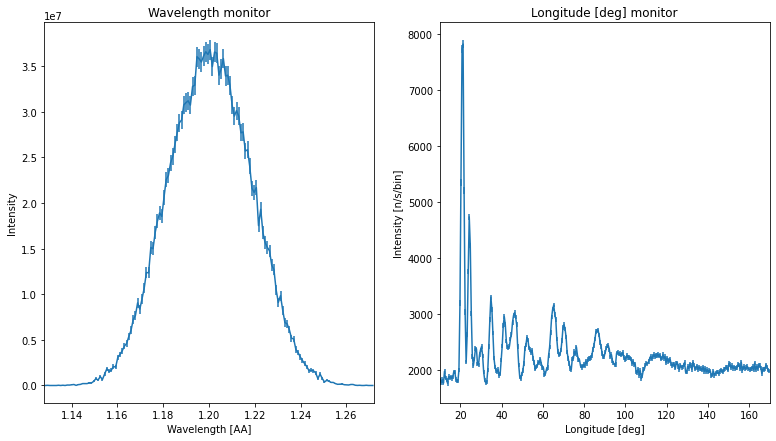

In [32]:
plotter.make_sub_plot(data)